In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
rcParams['legend.frameon'] = False
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import derived_data as d
import emcee
import corner
from scipy.stats import chi2

In [2]:
def log_normal_pdf(x, mu, sigma):
    return (np.exp(-((x - mu)**2 / (2 * sigma**2)))) / (sigma * np.sqrt(2 * np.pi))

def da(mu, sigma, a_min, a_max):
    return integrate.quad(lambda x: log_normal_pdf(x, mu, sigma), a_min, a_max)[0]

def dq(q_min, q_max):
    return integrate.quad(lambda q: q**.25 , q_min, q_max)[0]

def frequency(amp, q_min, q_max, mu, sigma, a_min, a_max):
    return amp * dq(q_min, q_max) * da(mu, sigma, a_min, a_max)

def red_chi_sq(nu, model, data, error):
    return sum((1/nu) * np.power(np.subtract(data, model), 2) / np.power(error, 2))

q_min = 0.6
q_max = 1.0
a_min = 0
a_max = 10000
nu = 3

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


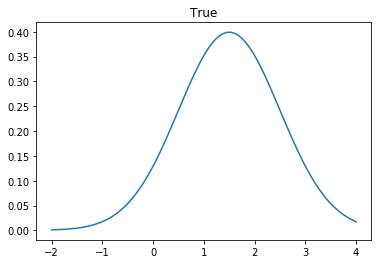

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


f_true = 0.3752019297592421


C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


In [3]:
np.random.seed(1)

A_true = 1
mu_true = 1.5
sigma_true = 1

a = np.linspace(a_min, a_max, 1e6)
x_true = np.log10(a)
y_true = log_normal_pdf(x_true, mu_true, sigma_true)

plt.plot(x_true, y_true)
plt.title("True")
plt.show()

f_true = frequency(1, q_min, q_max, mu_true, sigma_true, np.log10(a_min), np.log10(a_max))
print("f_true =", f_true)

f_1_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
f_2_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
f_3_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
f_4_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
f_5_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
f_6_true = frequency(A_true, q_min, q_max, mu_true, sigma_true, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))

## using small error
(e = 0.0001)

In [4]:
def lnLikelihood(p): # p[] = A, mu, sigma
    np.random.seed(1)
    
    e = 0.0001
    
    f_1_data = f_1_true + np.random.normal(0, e)
    f_2_data = f_2_true + np.random.normal(0, e)
    f_3_data = f_3_true + np.random.normal(0, e)
    f_4_data = f_4_true + np.random.normal(0, e)
    f_5_data = f_5_true + np.random.normal(0, e)
    f_6_data = f_6_true + np.random.normal(0, e) 
    
    f_1_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
    f_2_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
    f_3_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
    f_4_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
    f_5_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
    f_6_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))
    
    models = [f_1_model, f_2_model, f_3_model, f_4_model, f_5_model, f_6_model]
    data = [f_1_data, f_2_data, f_3_data, f_4_data, f_5_data, f_6_data]
    
#     nu = len(models) - len(p)
#     chi_sq_stat = red_chi_sq(nu, models, data, e)
#     p = np.exp(-chi_sq_stat/2)
#     p = chi2.pdf(nu * chi_sq_stat, nu)
    ll = np.nan_to_num(-0.5 * sum(np.power(np.subtract(data, models), 2) / np.power(e, 2)))

    return ll

def lnPrior(p):
    if not (0 < p[0] < 2): # wide: 0 - 2
        return -np.inf
    if not (-1 < p[1] < 2): # wide: -2 - 5
        return -np.inf
    if not (-1 < p[2] < 2): # wide: -2 - 4
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

ndim = 3
nwalkers = 100
nsteps = 5000
np.random.seed(0)

# p0 = [np.random.rand(ndim) for i in range(nwalkers)]
p0 = np.reshape([[np.random.uniform(0, 2, 1), np.random.uniform(-1, 2, 1), np.random.uniform(-1, 2, 1)] for i in range(nwalkers)], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
sampler.run_mcmc(p0, nsteps)
times = sampler.get_autocorr_time()

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


[23.85593308 31.43802199 23.31692979]
524.0725657181287


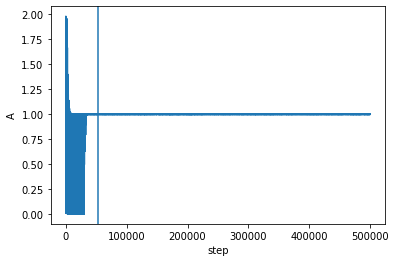

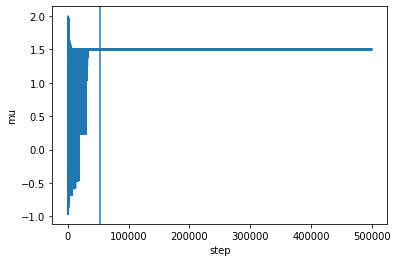

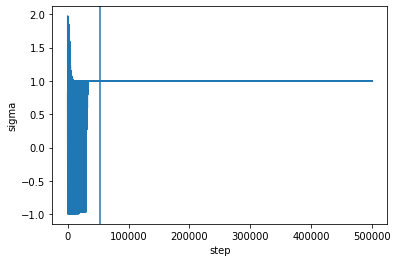

In [5]:
print(times)
print(20 * np.mean(times))

plt.plot(sampler.flatchain[:,0])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("A")
plt.show()
plt.plot(sampler.flatchain[:,1])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("mu")
plt.show()
plt.plot(sampler.flatchain[:,2])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("sigma")
plt.show()

(100, 5000, 3)


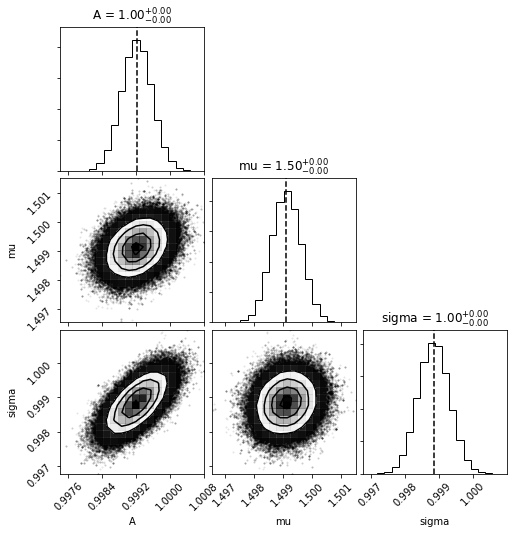

In [7]:
burns = 500
samples = sampler.chain[:, burns:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

corner.corner(samples, labels=['A', 'mu', 'sigma'], quantiles=[0.5], show_titles=True)
plt.show()

In [ ]:
# nsteps = 5000
# nburn = 20 * np.mean(times)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
# pos, prob, state = sampler.run_mcmc(p0, nburn)
# sampler.reset()
# sampler.run_mcmc(pos, nsteps, rstate0=state)

# print('A = {0:.3f} +- {1:.3f} mu = {2:.3f} +- {3:.3f}  sigma = {4:.3f} +- {5:.3f}'
#     .format(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]),
#     np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]),
#         np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2])))

In [ ]:
# plt.plot(sampler.flatchain[:,0])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("A")
# plt.show()
# plt.plot(sampler.flatchain[:,1])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("mu")
# plt.show()
# plt.plot(sampler.flatchain[:,2])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("sigma")
# plt.show()

In [ ]:
# corner.corner(sampler.flatchain, labels=['A', 'mu', 'sigma'], quantiles=[0.5], show_titles=True)
# plt.show()

## using errors from real data
(e = [e_1, e_2, e_3, e_4, e_5, e_6])

In [8]:
def lnLikelihood(p): # p[] = A, mu, sigma
    e_1 = d.e_CC
    e_2 = d.e_Del
    e_3 = d.e_Jan
    e_4 = d.e_FM
    e_5 = d.e_WD_A
    e_6 = d.e_WD_B
    e = [e_1, e_2, e_3, e_4, e_5, e_6]

    f_1_data = f_1_true + np.random.normal(0, e_1)
    f_2_data = f_2_true + np.random.normal(0, e_2)
    f_3_data = f_3_true + np.random.normal(0, e_3)
    f_4_data = f_4_true + np.random.normal(0, e_4)
    f_5_data = f_5_true + np.random.normal(0, e_5)
    f_6_data = f_6_true + np.random.normal(0, e_6)
        
    f_1_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
    f_2_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
    f_3_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
    f_4_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
    f_5_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
    f_6_model = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))
    
    models = [f_1_model, f_2_model, f_3_model, f_4_model, f_5_model, f_6_model]
    data = [f_1_data, f_2_data, f_3_data, f_4_data, f_5_data, f_6_data]
    
#     nu = len(models) - len(p)
#     chi_sq_stat = red_chi_sq(nu, models, data, e)
#     p = np.exp(-chi_sq_stat/2)
#     p = chi2.pdf(nu * chi_sq_stat, nu)
    ll = np.nan_to_num(-0.5 * sum(np.power(np.subtract(data, models), 2) / np.power(e, 2)))

    return ll

def lnPrior(p):
    if not (0 < p[0] < 2): # wide: 0 - 2
        return -np.inf
    if not (-1 < p[1] < 2): # wide: -2 - 5
        return -np.inf
    if not (-1 < p[2] < 2): # wide: -2 - 4
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

ndim = 3
nwalkers = 100
nsteps = 10000
np.random.seed(0)

# p0 = [np.random.rand(ndim) for i in range(nwalkers)]
p0 = np.reshape([[np.random.uniform(0, 2, 1), np.random.uniform(-1, 2, 1), np.random.uniform(-1, 2, 1)] for i in range(nwalkers)], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
sampler.run_mcmc(p0, nsteps)
times = sampler.get_autocorr_time()

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


[133.23450154 119.98895577 136.18098569]
2596.029620028375


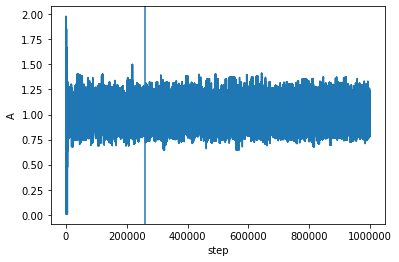

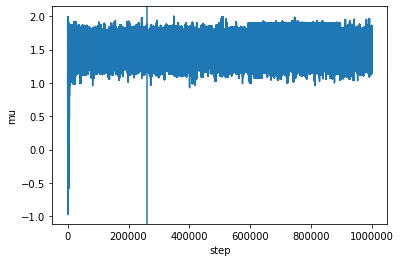

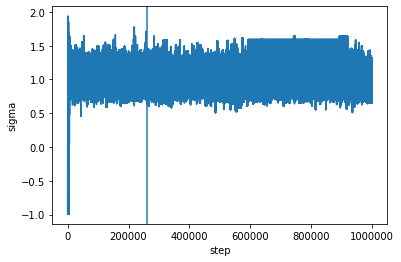

In [9]:
print(times)
print(20 * np.mean(times))

plt.plot(sampler.flatchain[:,0])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("A")
plt.show()
plt.plot(sampler.flatchain[:,1])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("mu")
plt.show()
plt.plot(sampler.flatchain[:,2])
plt.axvline(100* 20 * np.mean(times))
plt.xlabel("step")
plt.ylabel("sigma")
plt.show()

(100, 10000, 3)


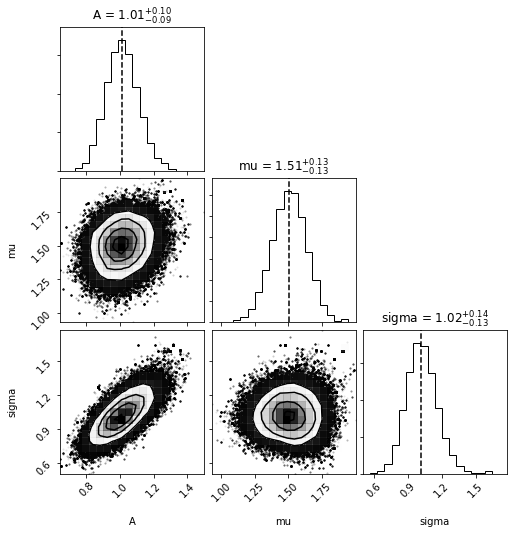

In [13]:
burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print (np.shape(sampler.chain))

corner.corner(samples, labels=['A', 'mu', 'sigma'], quantiles=[0.5], show_titles=True)
plt.show()

In [ ]:
# nsteps = 5000
# nburn = 20 * np.mean(times)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
# pos, prob, state = sampler.run_mcmc(p0, nburn)
# sampler.reset()
# sampler.run_mcmc(pos, nsteps, rstate0=state)

# print('A = {0:.3f} +- {1:.3f} mu = {2:.3f} +- {3:.3f}  sigma = {4:.3f} +- {5:.3f}'
#     .format(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]),
#     np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]),
#         np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2])))

In [ ]:
# plt.plot(sampler.flatchain[:,0])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("A")
# plt.show()
# plt.plot(sampler.flatchain[:,1])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("mu")
# plt.show()
# plt.plot(sampler.flatchain[:,2])
# plt.axvline(100* 20 * np.mean(times))
# plt.xlabel("step")
# plt.ylabel("sigma")
# plt.show()

In [ ]:
# corner.corner(sampler.flatchain, labels=['A', 'mu', 'sigma'], quantiles=[0.5], show_titles=True)
# plt.show()